In [1]:
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import sys
sys.path.append("../")
import analysis_util, tasks, general_network_visualization

AND experiment

In [11]:
data_path = "boolean_network_data/and_evolution_results/2023-03-13-21-10-14"
f_input_state = tasks.make_2_bit_input_state
f_eval = tasks.evaluate_and_task
input_nodes = [0, 1]
output_nodes = [2]

XOR experiment

In [23]:
data_path = "boolean_network_data/xor_evolution_results/2023-03-13-21-10-20"
f_input_state = tasks.make_2_bit_input_state
f_eval = tasks.evaluate_xor_task
input_nodes = [0, 1]
output_nodes = [2]

Shared AND experiment

In [33]:
data_path = "boolean_network_data/shared_and_evolution_results/2023-02-19-16-10-56"
f_input_state = tasks.make_3_bit_input_state
f_eval = tasks.evaluate_shared_and_task
input_nodes = [0, 1, 2]
output_nodes = [3, 4]

Sequential AND experiment

In [44]:
data_path = "boolean_network_data/sequential_and_evolution_results/2023-02-18-14-33-48/"
f_input_state = tasks.make_3_bit_input_state
f_eval = tasks.evaluate_sequential_and_task
input_nodes = [0, 1, 2]
output_nodes = [3, 4]

Parralel AND experiment

In [18]:
data_path = "boolean_network_data/parralel_and_evolution_results/2023-02-17-17-35-16/"
f_input_state = tasks.make_4_bit_input_state
f_eval = tasks.evaluate_pnand_task
input_nodes = [0, 1, 2, 3]
output_nodes = [4, 5]

In [19]:
data = np.load(os.path.join(os.getenv("DATA_DIR"), data_path, "batch_1.npz"))

In [4]:
N = data["N"]
input_state = cp.asnumpy(f_input_state(N))
best_functions = np.expand_dims(data["functions"], 1)
best_conn = np.expand_dims(data["connectivity"], 1)
best_used_conn = np.expand_dims(data["used_connectivity"], 1)
batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_state, 1), 1), (input_state.shape[0], np.shape(best_functions)[0], 1, N)).astype(np.bool_)

In [6]:
best_functions, best_conn, best_used_conn, sorted_perfs, _ =  analysis_util.sort_by_performance(cp.array(batched_input_state), cp.array(best_functions), cp.array(best_conn), cp.array(best_used_conn), f_eval, n_trajectories=int(10000/input_state.shape[0]))

In [77]:
graphs = [general_network_visualization.influence_graph_from_ragged_spec(f[0, :, :], c[0, :, :], uc[0, :, :]) for f, c, uc in zip(cp.asnumpy(best_functions), cp.asnumpy(best_conn), cp.asnumpy(best_used_conn))]
[g.remove_nodes_from(list(nx.isolates(g))) for g in graphs]
[general_network_visualization.prune_non_participating(g, input_nodes + output_nodes) for  g in graphs]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

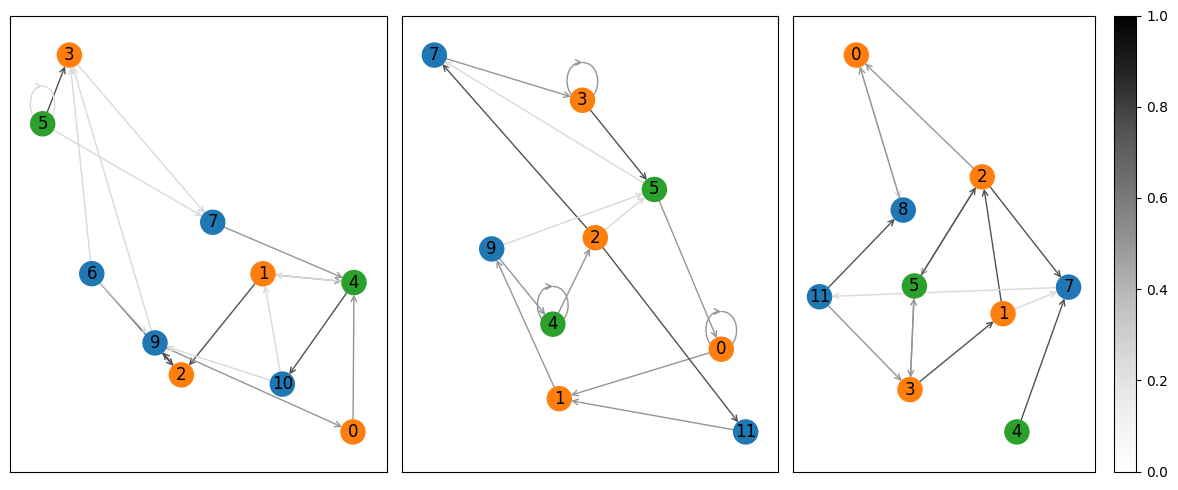

In [65]:
best_to_plot = 3
to_plot = graphs[:best_to_plot]
fig, axs = plt.subplots(ncols=len(to_plot), figsize=(12,5))
node_colors = ["C0"] * int(N)

for x in input_nodes:
    node_colors[x] = "C1"
for x in output_nodes:
    node_colors[x] = "C2"


for i, (g, ax, err) in enumerate(zip(graphs, axs, sorted_perfs[:best_to_plot])):
    pos = nx.spring_layout(g, iterations=40)
    colorbar = True if i==best_to_plot-1 else False
    general_network_visualization.plot_network_directed(g, pos, ax, node_colors[:len(g.nodes)], colorbar=colorbar)
fig.tight_layout()

In [66]:
example_trajs, example_noise = analysis_util.run_dynamics_forward_save_state(cp.array(batched_input_state), best_functions, best_conn, best_used_conn, 7, 0)
example_trajs = np.squeeze(example_trajs, -2)
example_noise = np.squeeze(example_noise, -2)

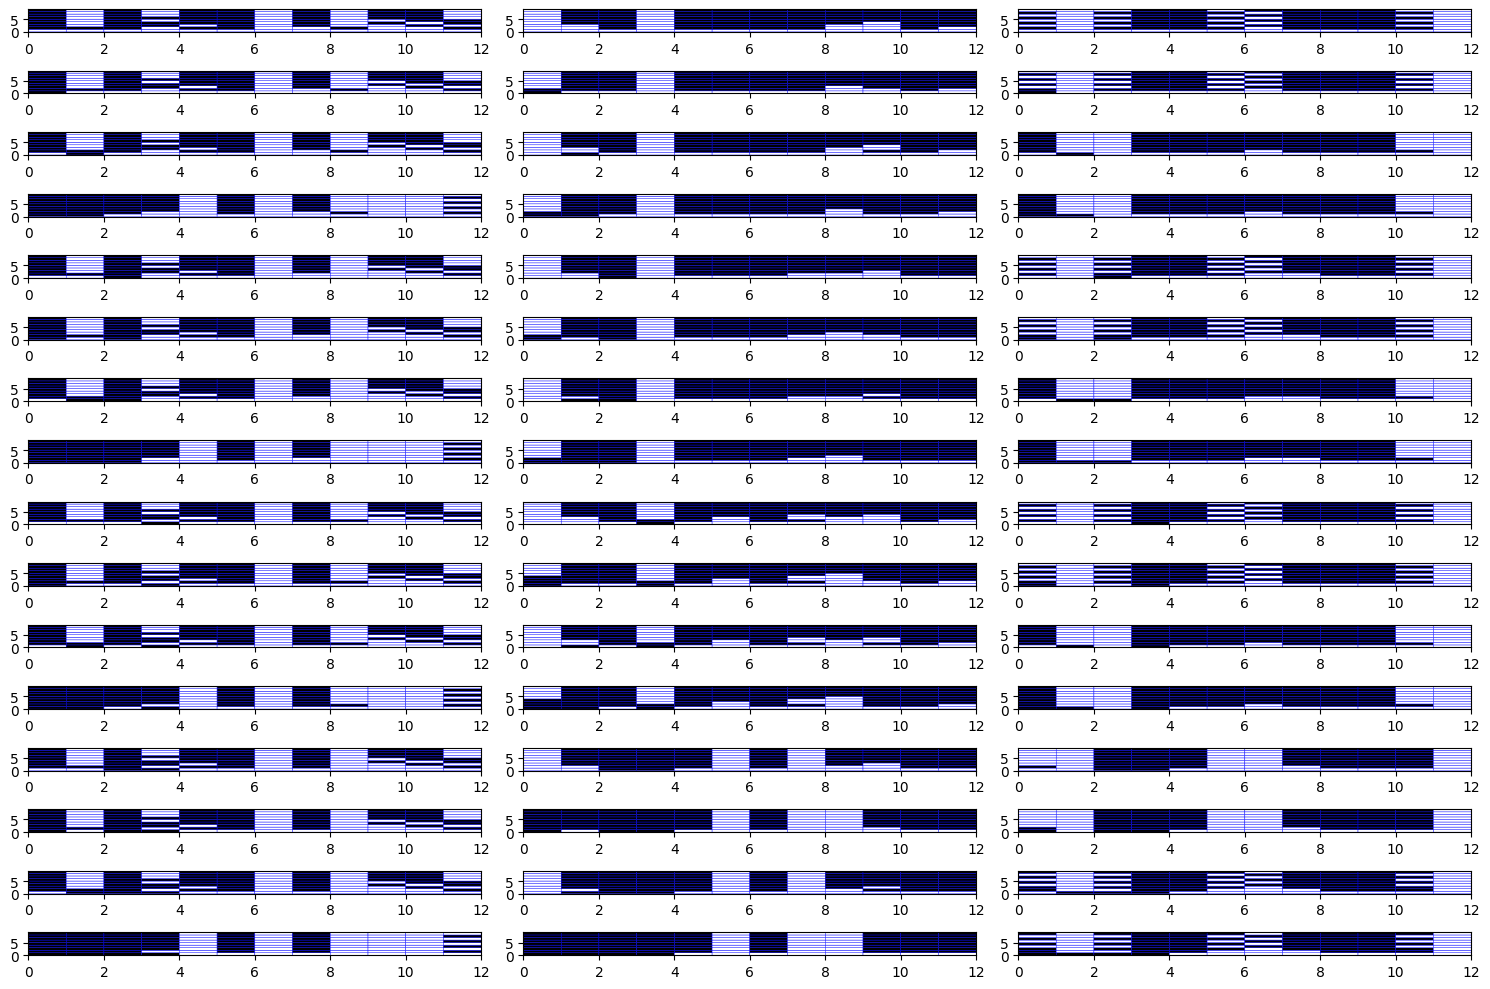

In [67]:
fig, axs = plt.subplots(nrows=example_trajs.shape[1], ncols=best_to_plot, figsize=(15, 10))
for i in range(best_to_plot):
    for j in range(example_trajs.shape[1]):
        axs[j, i].pcolor(cp.asnumpy(example_trajs[:, j, i, :]), cmap="Greys", linewidth=0.3, edgecolors="blue")
fig.tight_layout()

In [68]:
physical_error_rates = np.linspace(start=0, stop=0.01, num=20)
logical_error_rates = analysis_util.generate_ft_curve(physical_error_rates, cp.array(batched_input_state), cp.array(best_functions), cp.array(best_conn), cp.array(best_used_conn), f_eval, n_traj=5000)
logical_error_rates = cp.asnumpy(logical_error_rates)

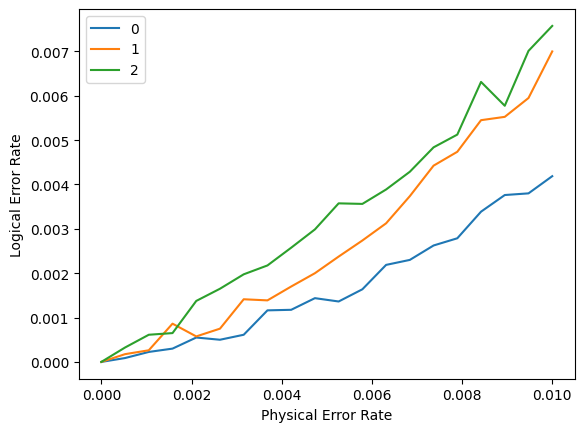

In [53]:
fig, axs = plt.subplots()
logical_error_rates = np.array(logical_error_rates)
for j in range(best_to_plot):
    axs.plot(physical_error_rates, logical_error_rates[:, j], label="{}".format(j))
axs.set_xlabel("Physical Error Rate")
axs.set_ylabel("Logical Error Rate")
axs.legend()
